<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC2</p>
<p style="margin: 0; text-align:right;">2020-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicacions</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 2: Mètodes no supervisats

Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades, així com algunes de les seves aplicacions reals:

 - **Clustering amb diferents estratègies**: k-means i regla del colze, basades en densitat i jeràrquiques.
 - **Optimizació amb reducció de dimensionalitat**: t-SNE.
 - **Aplicació**: identificació de punts d'interès turístics.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nom i cognoms:</strong>
</div>

In [1]:
print("Claudia Puche Garcia")

Claudia Puche Garcia


---

Per realitzar aquesta pràctica, necessitarem les següents llibreries:

In [2]:
import numpy as np
import pandas as pd
import random
import sklearn
from sklearn import cluster                   # Algorismes de clustering.
from sklearn import datasets                  # Crear datasets.
from sklearn import manifold                  # Algorismes de reducció de dimensionalitat.
from sklearn import decomposition             # Mòdul de reducció de dimensionalitat.
from sklearn.utils import check_random_state  # Gestió de números aleatoris.

# Clustering jeràrquic i dendrograma.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# UMAP per la reducció de dimensionalitat.
import umap

# Visualització.
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl



%matplotlib inline

## 1. Mètodes de *clustering* (4 punts)

Aquest exercici tracta d'explorar diferents tècniques d'agrupament ajustant-les a diferents conjunts de dades.

L'objectiu és doble: entendre l'influència dels paràmetres en el seu comportament, i coneixer les seves limitacions en la recerca d'estructures de dades.

### Generació dels conjunts de dades

In [3]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset té 2 variables: una variable *X* que conté dues features (columnes) i tantes files com mostres. I una variable *y* que conté les etiquetes que identificaran cada cluster.

Al llarg de l'exercici no s'utilitzarà la variable *y* (només amb l'objectiu de visualtizar). L'objectiu és, mitjançant els diferents models de *clustering*, aconseguir trobar les estructures descrites per les variables *y*.

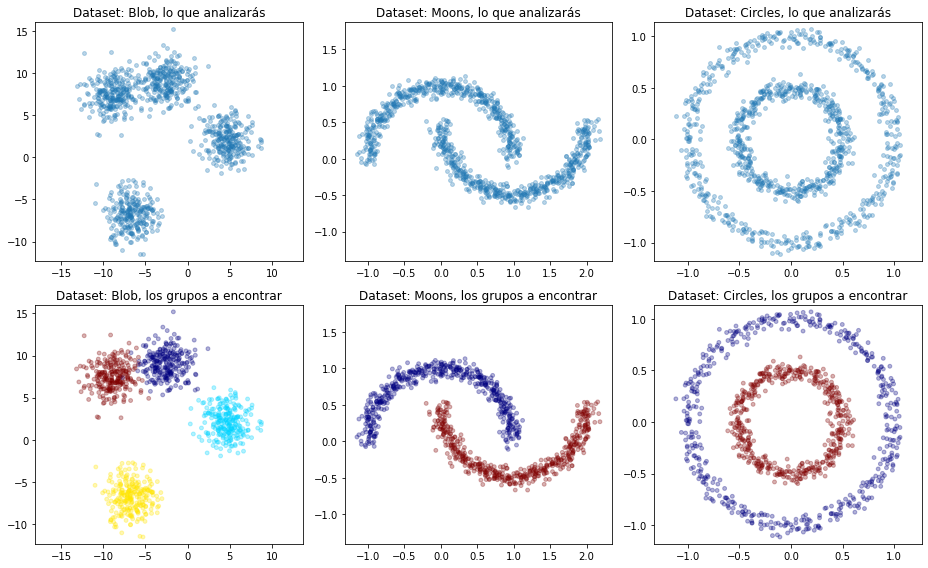

In [4]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En aquest apartat es demana provar l'algorisme *k-means* sobre els tres datasets presentats anteriorment ajustant amb els paràmetres adecuats i analitzar-ne els resultats.

In [5]:
X, y = X_blobs, y_blobs

Es demana estimar el nombre de clústers a detectar per *k-means*. Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clústers a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen a l'i-èsim clúster, $c_i $ és el centroide del clúster $C_i$ (al que pertany el punt $x$), i $euclidean$ és la [distància euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent on l'eix $x$ representa els diferents valors de $k$, i l'eix $i$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $ k $.

**Es demana realitzar la representació gràfica de la regla del colze amb la seva interpretació, utilitzant la llibreria `` `matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Blobs.
</div>

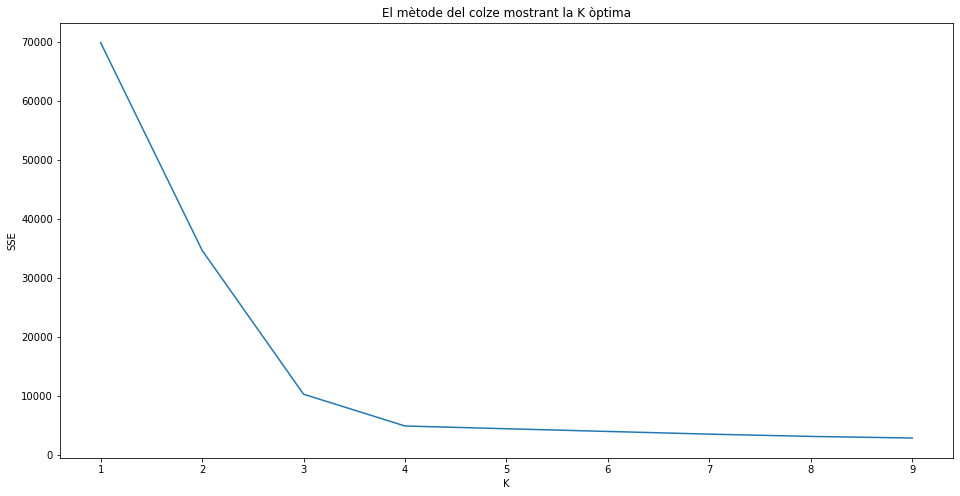

In [6]:
# S'importa la implementació de k-means de la llibreria scikit-learn
from sklearn.cluster import KMeans

# Estudi dels K centroides a identificar segons la minimització de SSE
SSE = []
K = range(1,10)
for k in K:
    kmean_blobs = KMeans(n_clusters=k)
    kmean_blobs.fit_transform(X)
    SSE.append(kmean_blobs.inertia_)


# Graficam SSE en funció de k
plt.figure(figsize=(16,8))
plt.plot(K, SSE)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('El mètode del colze mostrant la K òptima')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què s'interpreta a la gràfica? Com podria millorar-se l'elecció de $k$?.  
</div>

Una de les principals caracterítiques de k-means és que s'ha d'indicar un número K de particions o clústers a identificar. Un dels criteris és minimitzar la suma de residus quadrats (RSS), és a dir, la suma de les distàncies de qualsevol vector o instància al seu centroide més proper.

En aquest cas, a partir de k = 4, la millora que es produeix en la distància interna dels segments és molt petita. És a dir, indica que k = 4 és un valor adequat. Malgrat això, aquest indicador només mesura la distància intragrup (dintre del grup). Per aquesta raó que el mètode del colze pot ser complementat amb un altre mètode que tingui en compte la distància intergrups com per exemple el mètode de Calinski-Harabasz:

- El **coficient de calinski_harabasz** calcula el ràtio de la dispersió entre clusters. És a dir, és una mesura que calcula com de similar és una observació amb el seu propi cluster (cohesió) comparat amb els altres clústers (dispersió).

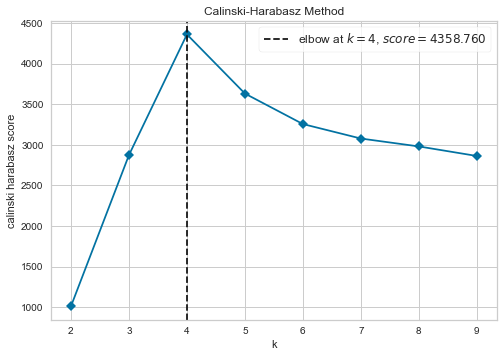

<AxesSubplot:title={'center':'Calinski-Harabasz Method'}, xlabel='k', ylabel='calinski harabasz score'>

In [7]:
# Importam les llibreries necessàries per visualitzar el mètode Calinski-Harabasz
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Graficam el mètode
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(2,10), 
                              metric='calinski_harabasz', 
                              timings=False, 
                              title='Calinski-Harabasz Method', 
                              xlabel='k', 
                              ylabel='Calinski-Harabasz Score')
visualizer.fit(X)
visualizer.poof()

La gràfica mostra com el punt més elevat i, per tant, la millor puntuació del mètode de Calinski - Harabasz és k = 4, suggerint que el nombre òptim de clústers és 4. Per altra banda, també es pot analitzar el coficient de la silueta.

- El **coeficient de la silueta** evalua la qualitat del clúster mitjançant la mitjana de la distància intra-cluster i la mitjana de la distància al pròxim cluster per cada observació. Per tant, intenta mesurar com de correcte s’agrupen les mostres amb altres mostres similars entre si.

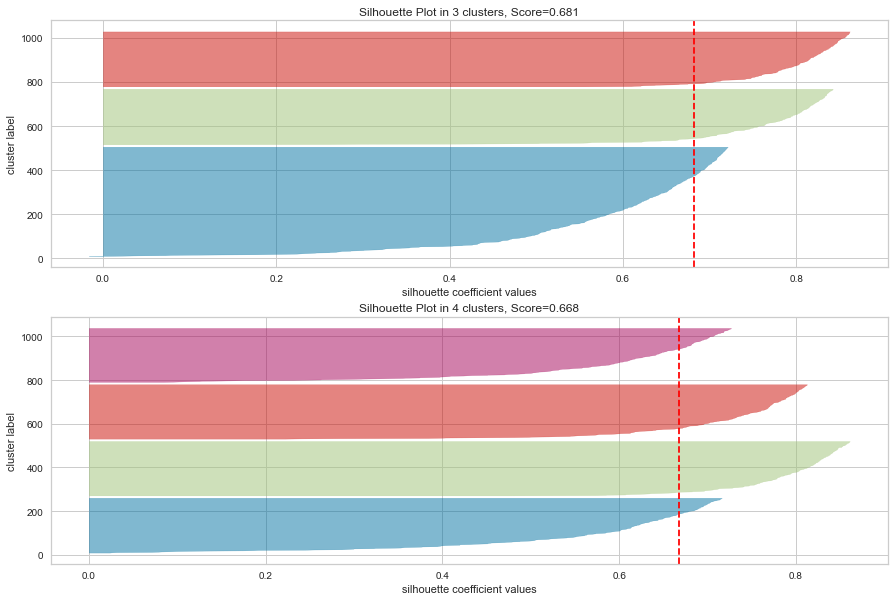

In [8]:
# Graficam el coeficient de la silueta per k = 3 i k = 4.
fig, axes = plt.subplots(2, 1, figsize=(15,10))
axes_flat = axes.flatten()
i=0

# Iteram per cada k
for k in range(3,5,1):
    model = KMeans(k, random_state=42)
    ax=axes_flat[i]   
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes_flat[i])
    visualizer.fit(X)
    ax.set_title(f'Silhouette Plot in {k} clusters, Score={visualizer.silhouette_score_:.3f}')
    ax.set(xlabel='silhouette coefficient values', ylabel='cluster label')
    i=i+1

plt.show()

En el coeficient de la silueta el Silhouete score pren valors entre el -1 i 1. Si el valor és 1, el clúster és dens i està separat correctament dels altres clústers. Per altra banda, un valor al voltant del 0 representa clústers sobreposats amb mostres molt properes als centroides del clústers veïns. Finalment, un score negatiu indica que la mostra pot haver estat assignat al clúster equivocat.

En aquest cas, es poden extreure les seguents conclusions:
- En els dos escenaris els clústers es troben per sobre de la mitjana de la puntuació del mètode, per tant, es podrien considerar correctes.
- En el cas de k = 3 s'obté un score un poc més alt que amb k = 4 (0.68 vs 0.66)
- El gruix dels clústers amb k = 4 és proporcionalment uniforme per tots els grups, mentre que amb k = 3 el segon clúster és molt més gruixut que els altres.
- Tenint en compte la insignificant diferència entre les puntuacions i que les proporcions dels diferents grups quan k=3 són molt diferents, sembla que el número òptim el k = 4.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Blobs.
</div>

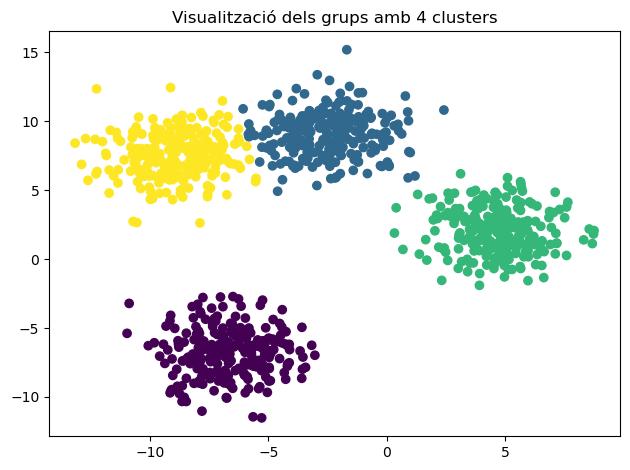

In [10]:
# Visualització dels grups amb k = 4

fig, ax = plt.subplots(1, 1)

model = KMeans(n_clusters=4)
y_pred = np.argmin(model.fit_transform(X), axis=1)

ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title('Visualització dels grups amb 4 clusters')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué ha passat? Explica els motiuss pels que creus que s'ha obtingut aquest resultat.
</div>

El resultat obtingut és el que s'esperava, ja que l'algorisme KMeans agrupa les observacions basant-se en la minimització de les distàncies al centroide. Una vegada establert el número de clústers que dividiran les dades, l'algorisme asigna les observacions al centroide més proper i aquest l'actualitza utilitzant la posició del promig de les observacions de cada grup. Per tant, amb aquest tipus de dades que són rodones i agrupades sembla que tant l'algorisme k-means com els diferents mètodes de selecció del valor òptim k resulten eficients.

In [11]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Moons.
</div>

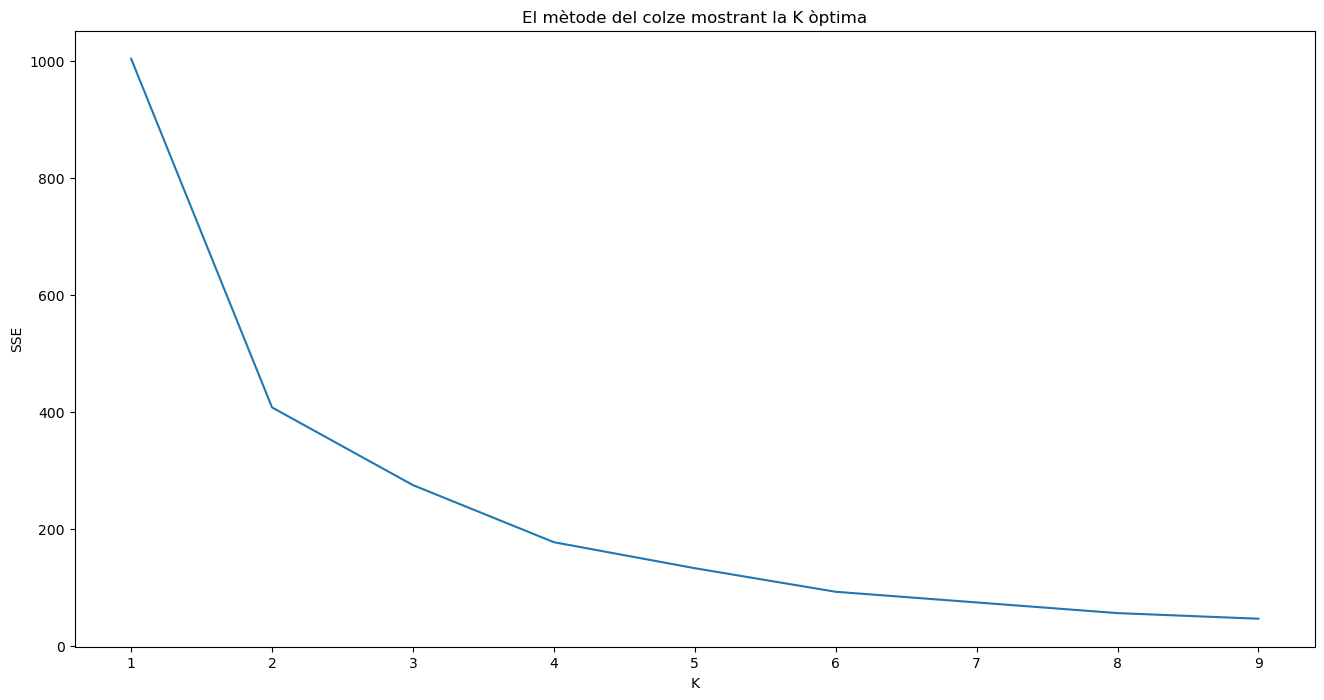

In [12]:
# Estudi dels K centroides a identificar segons la minimització de SSE
SSE = []
K = range(1,10)
for k in K:
    kmean_moons = KMeans(n_clusters=k)
    kmean_moons.fit_transform(X)
    SSE.append(kmean_moons.inertia_)


# Graficam SSE en funció de k
plt.figure(figsize=(16,8))
plt.plot(K, SSE)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('El mètode del colze mostrant la K òptima')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué se interpreta a la gràfica? ¿Com podria millorar-se l'elecció de $k$?.  
</div>

En aquest cas el mètode del colze mostra que el número òptim de clústers és igual a 2, ja que el punt d'inflexió es troba a k = 2. Tot i així, el mètode del colze es pot complementar mitjançant el gràfic del mètode de Calinski - Harabasz.

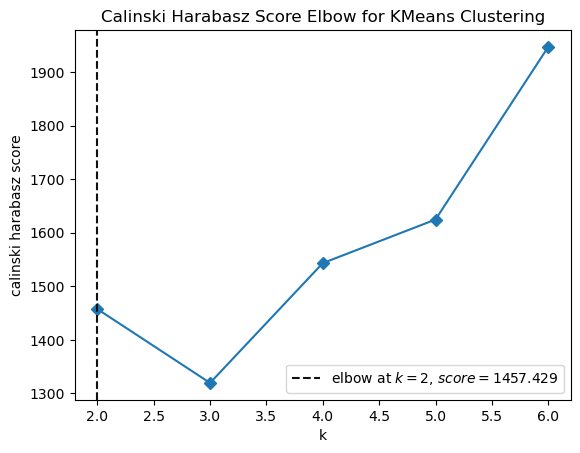

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), metric='calinski_harabasz', timings=False)
visualizer.fit(X)
visualizer.poof()

Es pot comprobar com en aquest cas el mètode de Calinski-Harabasz indica que la k òptima és igual a 2.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Moons.
</div>

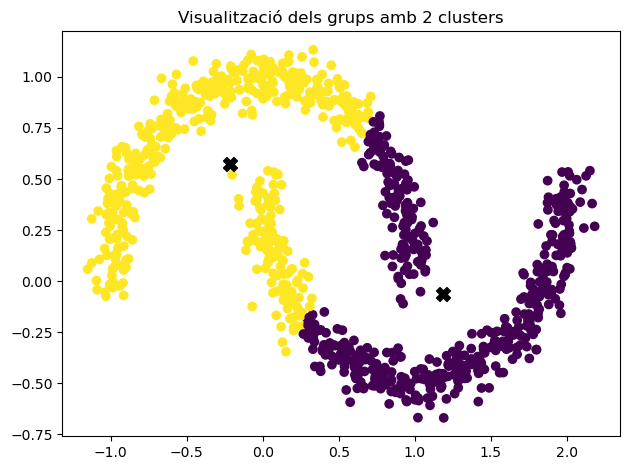

In [14]:
# Visualització dels grups amb k = 2
fig, ax = plt.subplots(1, 1)

model = KMeans(n_clusters=2)
y_pred = np.argmin(model.fit_transform(X), axis=1)
centroids = model.cluster_centers_

ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s = 100, marker='X')
ax.set_title('Visualització dels grups amb 2 clusters')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat. 
</div>

Es pot observar que l'algorisme kmeans no ha aconseguit separar correctament els clústers, ja que cada mitja circumferència conformaria un grup diferent. Aquest resultat s'ha obtingut perquè l'algorisme kmeans sembla que funciona quan el dataset estudiat té formes esfèriques. És a dir, l'assignació dels centroides té sentit quan les observacions del mateix clúster es troben al voltant d'aquests punts establerts. Per aquesta raó, kmeans no sembla tenir en compte les formes o direccions de les observacions del dataset i no sempre resulta ser un bon indicador de classificació.

In [15]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Circles.
</div>

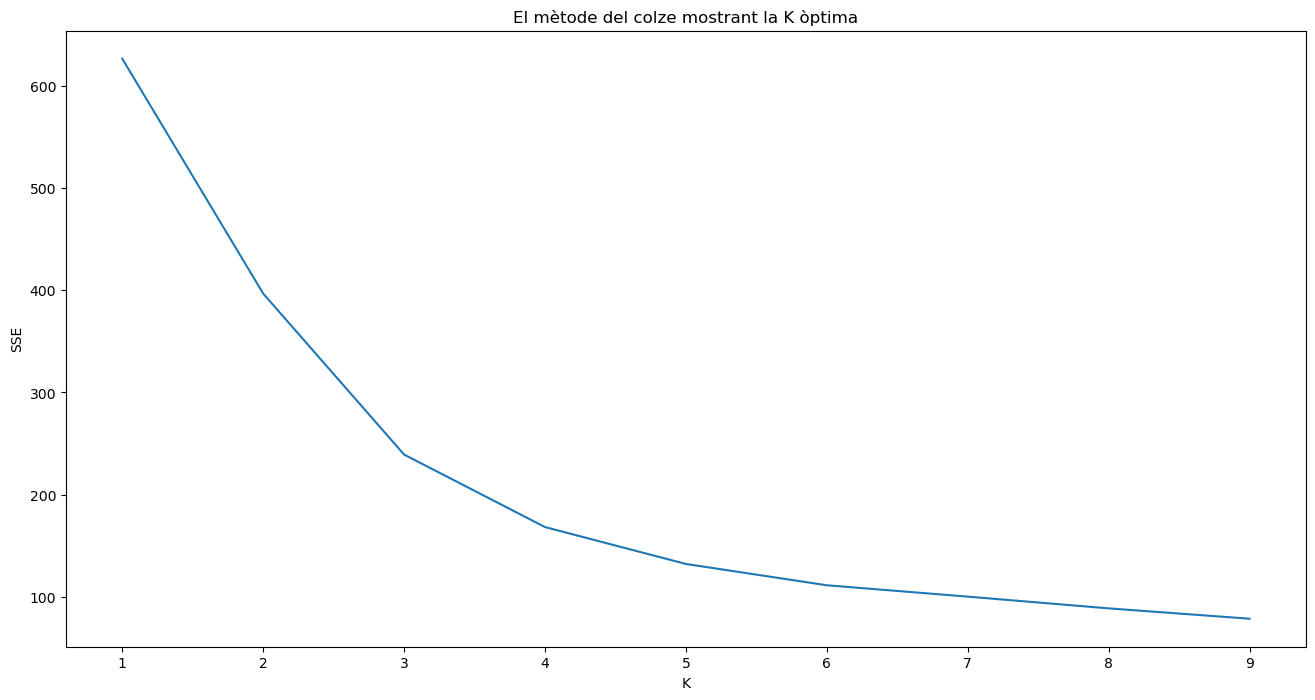

In [16]:
# Estudi dels K centroides a identificar segons la minimització de SSE
SSE = []
K = range(1,10)
for k in K:
    kmean_circles = KMeans(n_clusters=k)
    kmean_circles.fit_transform(X)
    SSE.append(kmean_circles.inertia_)


# Graficam SSE en funció de k
plt.figure(figsize=(16,8))
plt.plot(K, SSE)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('El mètode del colze mostrant la K òptima')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué s'interpreta a la gráfica? Com podria millorar-se l'elecció de $k$?.  
</div>

En aquest cas la gràfica del colze no indica cap valor obvi a simple vista.

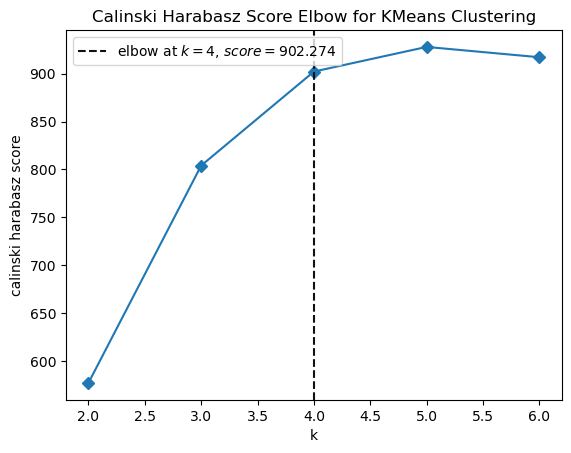

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [17]:
# Obtenció de la k òptima amb el mètode de Calinski-Harabasz
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), metric='calinski_harabasz', timings=False)
visualizer.fit(X)
visualizer.poof()

Per altra banda, el mètode de Calinski-Harabasz indica que la k òptima és igual a 4.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Circles.
</div>

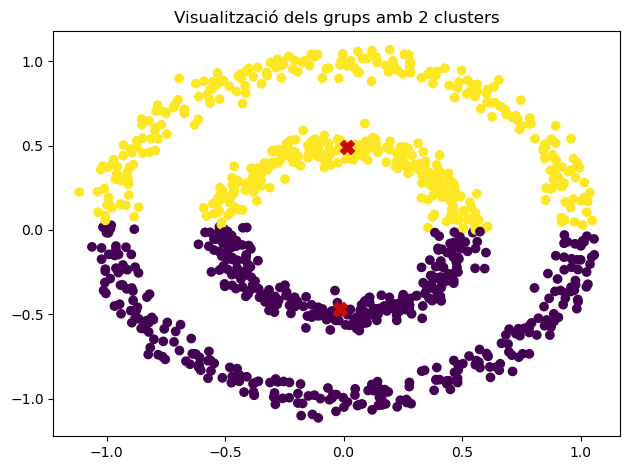

In [18]:
# Visualització dels grups amb k = 2
fig, ax = plt.subplots(1, 1)

model = KMeans(n_clusters=2)
y_pred = np.argmin(model.fit_transform(X), axis=1)
centroids = model.cluster_centers_

ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s = 100, marker='X')
ax.set_title('Visualització dels grups amb 2 clusters')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

Al igual que amb el dataset de les mitjes llunes, l'algorisme kmeans no realitza una bona aproximació de classificació. Realment, sí que realitza la seva funció correctament, ja que identifica un centre i el va reacomodant iteració rere iteració. L'output final divideix les dues circumferències en dos grups separades pel seu diàmetre. El principal motiu pel qual kmeans no ha resultat ser un mètode òptim de classificació té a veure amb la distribució de les dades estudiades, ja que com ja s'ha vist anteriorment no es té en compte la densitat, forma o direcció de les observacions del dataset.

### 1 b. Algorismes basats en densitat: DBScan

En aquest apartat es demana aplicar clustering per densitat com [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) als datasets anteriors per detectar els grups subadjacents.

In [19]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Blobs.
</div>

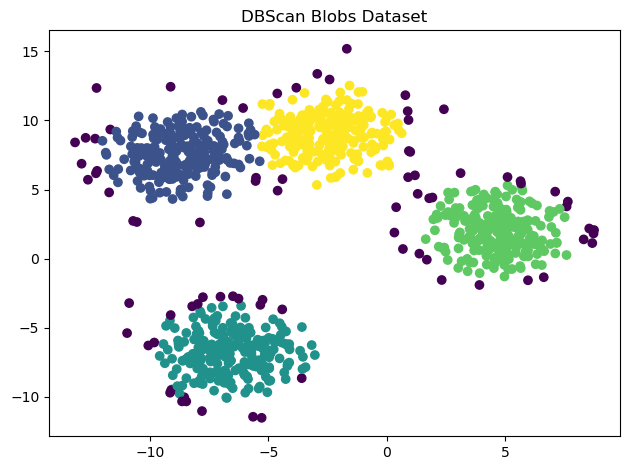

In [20]:
#Importam la llibreria necessària per executar l'algorisme
from sklearn.cluster import DBSCAN

dbscan = cluster.DBSCAN(eps=1.6, min_samples=50)
y_pred = dbscan.fit_predict(X)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title('DBScan Blobs Dataset')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

L'algorisme DBScan és conegut com un agrupament espacial basat en la densitat. L'avantatge d'aquest algorisme és que té en compte la densitat de les observacions que precisament és una de les principals carències del k-means. Per tant, aquest mètode considera i separa les zones en funció de si són lo suficientment denses. 

Una altra avantatge és que per executar aquest algorisme no fa falta que s'especifiqui un nombre òptim de clústers (k) com al k-means. Els paràmetres que s'han de definir en aquest cas és el nombre mínim d'observacions que constituiran un clúster (min_samples) i la mida que ha de tenir amb els seus veïns (epsilon).

Per entendre millor aquest algorisme, és correcte veure els diferents outputs segons la variació dels paràmetres.

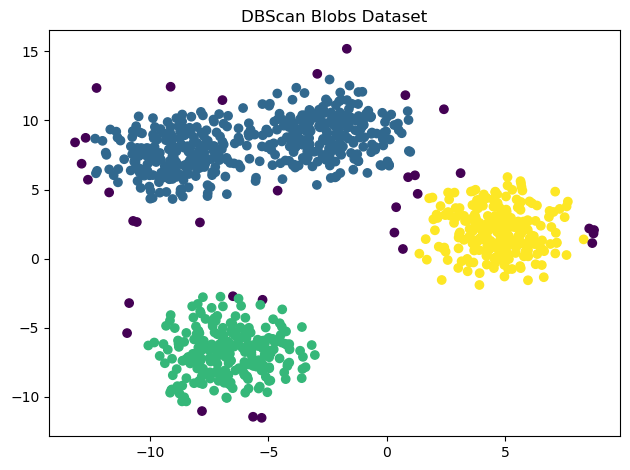

In [21]:
dbscan = cluster.DBSCAN(eps=1.8, min_samples=50)
y_pred = dbscan.fit_predict(X)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title('DBScan Blobs Dataset')
plt.tight_layout()

Es pot comprobar com al augmentar la variància entre el grups, per una banda deixen d'haver-hi punts aïllats entre els grups inferiors (verd i groc) però identifica com a un sol grup els dos clústers superiors.

In [22]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de DBScan jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Moons.
</div>

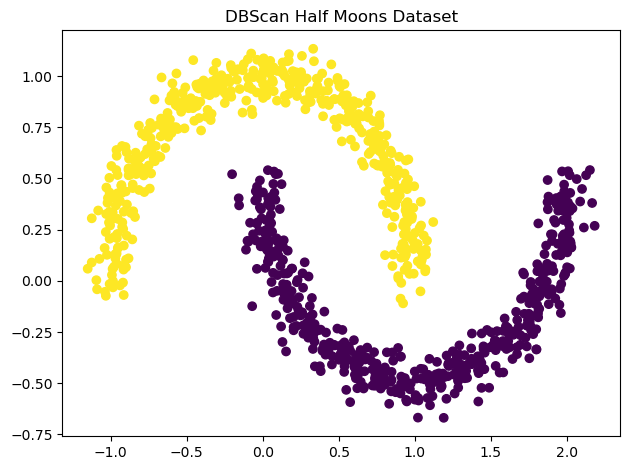

In [23]:
dbscan = cluster.DBSCAN(eps=0.2, min_samples=8)
y_pred = dbscan.fit_predict(X)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title('DBScan Half Moons Dataset')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

S'ha obtingut aquest resultat, ja que que aquest dataset està dividit en grups basats en la densitat. A diferència del dataset de Blobs la distància entre els grups és inferior, ja que els grups es troben molt més aïllats i sense outliers.

In [24]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de DBScan jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Circles.
</div>

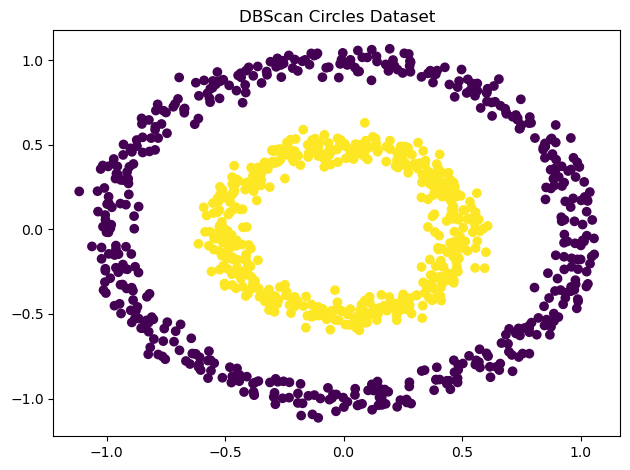

In [25]:
dbscan = cluster.DBSCAN(eps=0.2, min_samples=50)
y_pred = dbscan.fit_predict(X)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:,0], X[:,1], c=y_pred)
ax.set_title('DBScan Circles Dataset')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

Aquest resultat s'assembla al dataset de Half Moon, ja que amb un epsilon molt petit, l'algorisme pot definir amb major precisió els grups. És a dir, la distància entre les observacions del mateix grup no poden estar a una distància superior a 0.2

### 1 c. Algorismes jeràrquics

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algorisme jeràrquic aglomeratiu (estratègia *bottom-up*). La idea és trobar un mètode gràfic per entendre el comportament de l'algorisme i trobar els *clusters* desitjats en cada dataset. 

In [26]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Blobs.<br>
Pots importar les llibraries necessàries.
</div>

Els dendrogrames són un tipus de representació gràfica o digrama de dades que tenen forma d'arbre. Aquest algorisme organitza les dades en subcategories que es van dividint en vranques fins a arribar a un output desitjat. Addicionalment, aquest mètode permet executar l'algorisme amb diferents tipus de linkage. A continuació es graficaran quatre tipus de links jeràrquics: ward, complete, average i single.

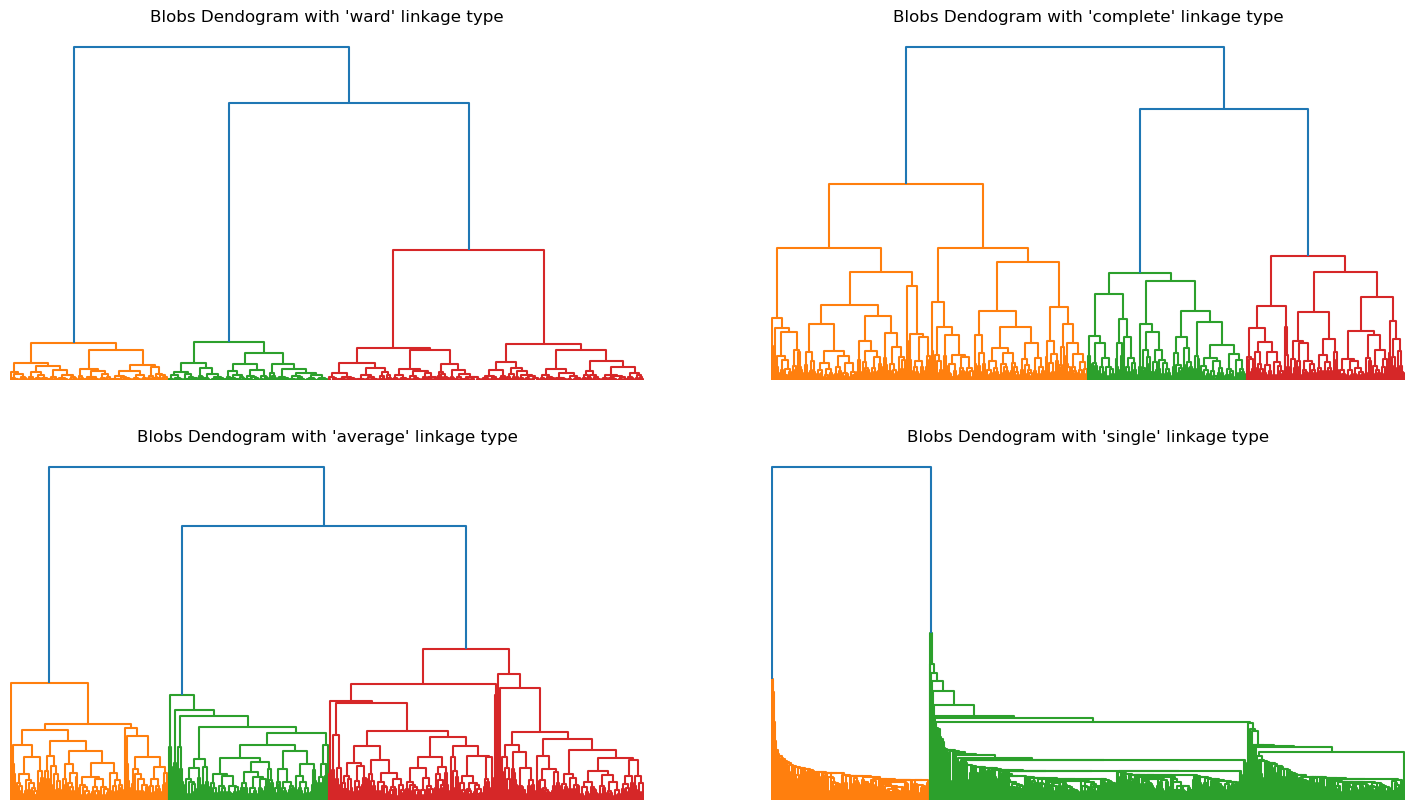

In [27]:
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(18, 10))
for index, link in enumerate(("ward",
                              "complete",
                              "average",
                              "single")):
    plt.subplot(2, 2, index + 1)
    Z = linkage(X, method = link)
    dendro = dendrogram(Z)
    plt.title('Blobs Dendogram with %r linkage type' % (link))
    plt.axis('off')

plt.show()

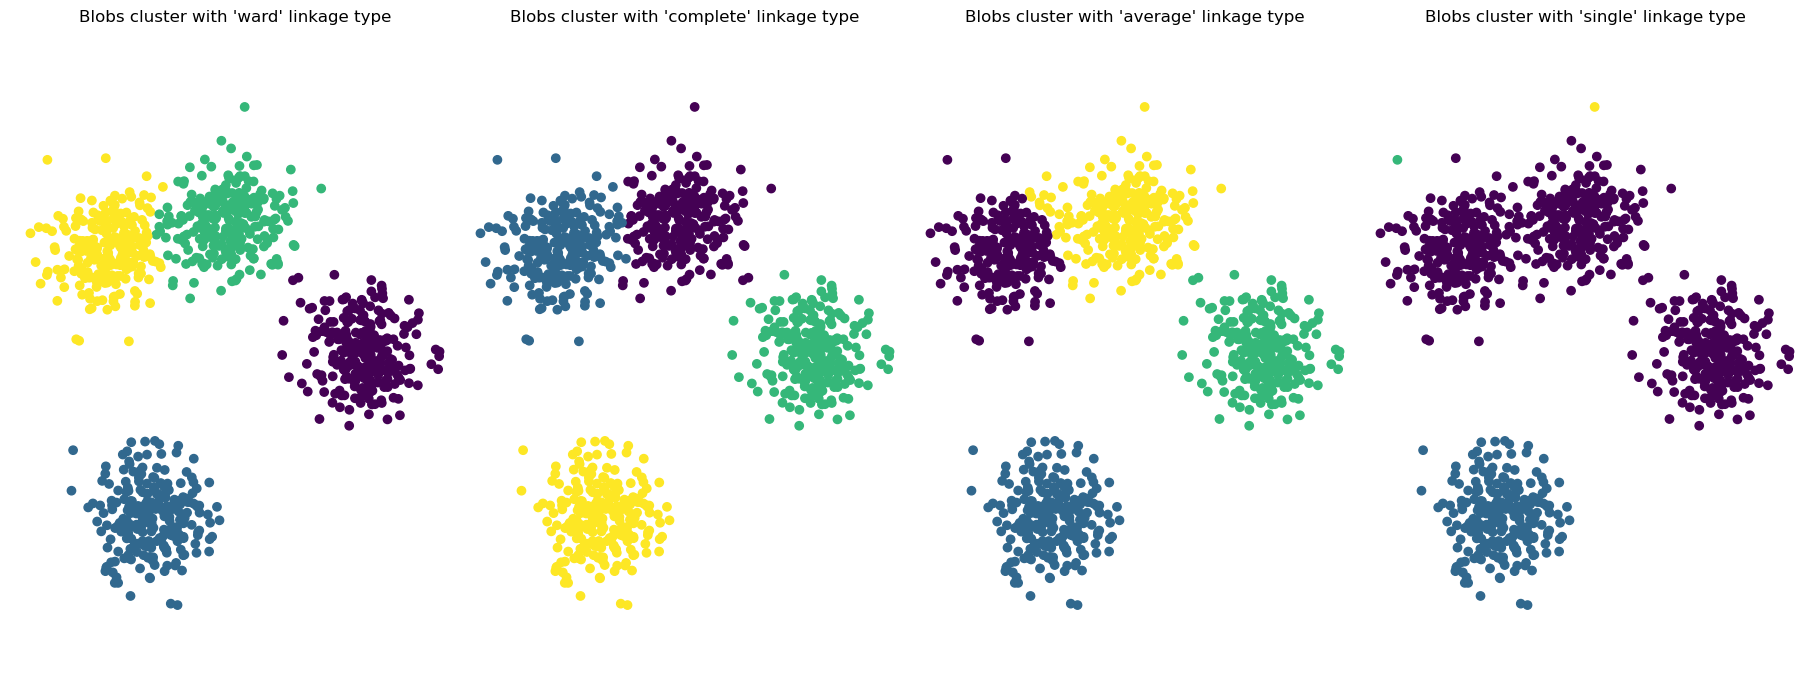

In [28]:
plt.figure(figsize=(18, 8))
for index, linkage in enumerate(("ward",
                              "complete",
                              "average",
                              "single")):
    plt.subplot(1, 4, index + 1)
    model = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    model.fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_)
    plt.title('Blobs cluster with %r linkage type' % (linkage),
                      fontdict=dict(verticalalignment='top'))
    plt.axis('equal')
    plt.axis('off')

    plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                                left=0, right=1)


plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

A primera vista es pot observar com els tres primers tipus de link han realitzat correctament la classifació, tot i que l'últim tipus (single) ha ajuntat en un sol clúster aquells grups que es trobaben més aprop. Una de les raons per les quals aquest tipus de link ha obtingut aquest output és precisament per aquesta raó. És a dir, al principi totes les observacions constitueixen un sol cúster fins que es van ajuntant, si ens fixem existeixen dues observacions adalt que són dos grups diferents. Per tant, es podria dir que aquest tipus de link agrupa als veïns propers i que per clústers que no es trobin diferenciats per grans distàncies no resultaria òptim.

In [29]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Moons.<br>
Pots importar les llibraries necessàries.
</div>

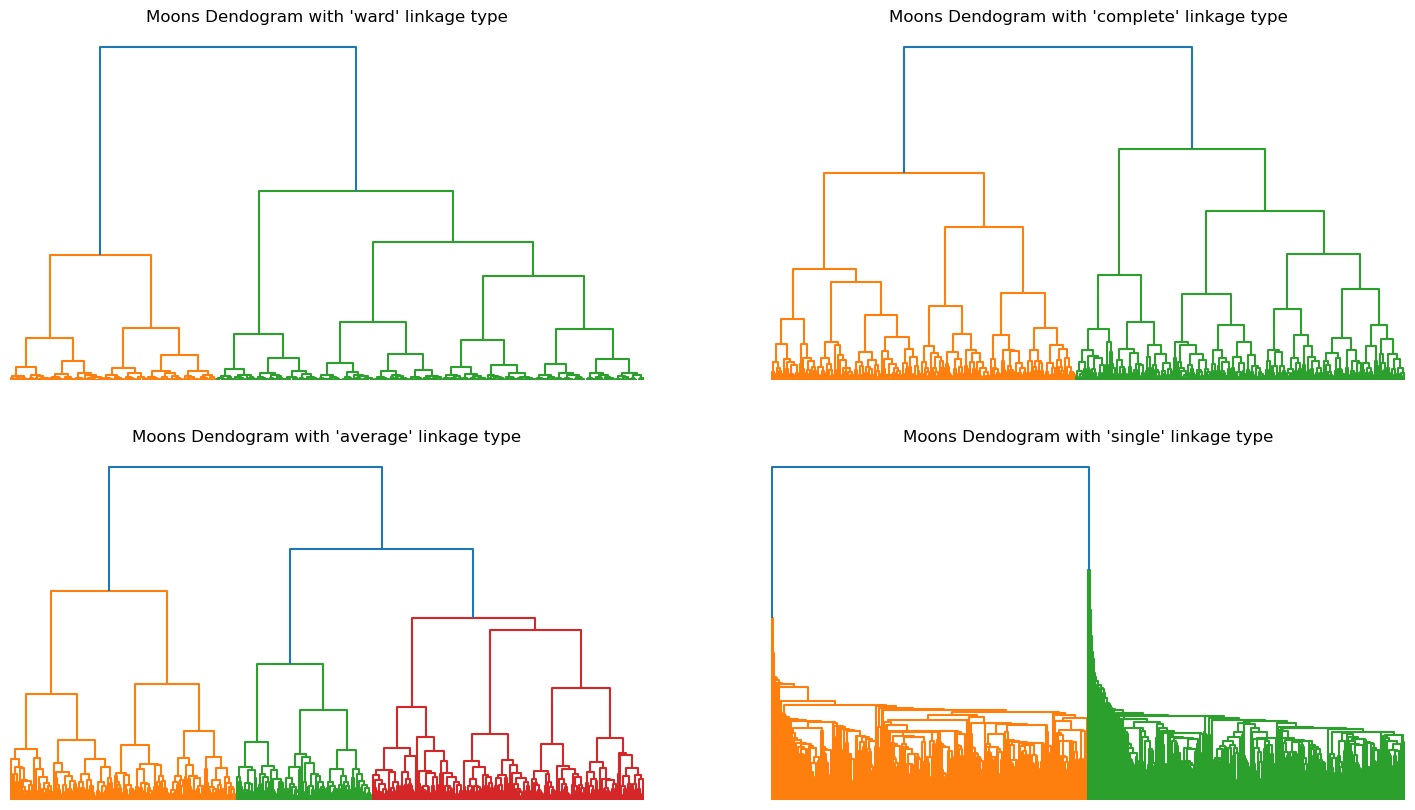

In [30]:
from scipy.cluster.hierarchy import dendrogram , linkage

plt.figure(figsize=(18, 10))
for index, link in enumerate(('ward',
                              'complete',
                              'average',
                              'single')):
    plt.subplot(2, 2, index + 1)
    Z = linkage(X, method = link)
    dendro = dendrogram(Z)
    plt.title('Moons Dendogram with %r linkage type' % (link))
    plt.axis('off')

plt.show()

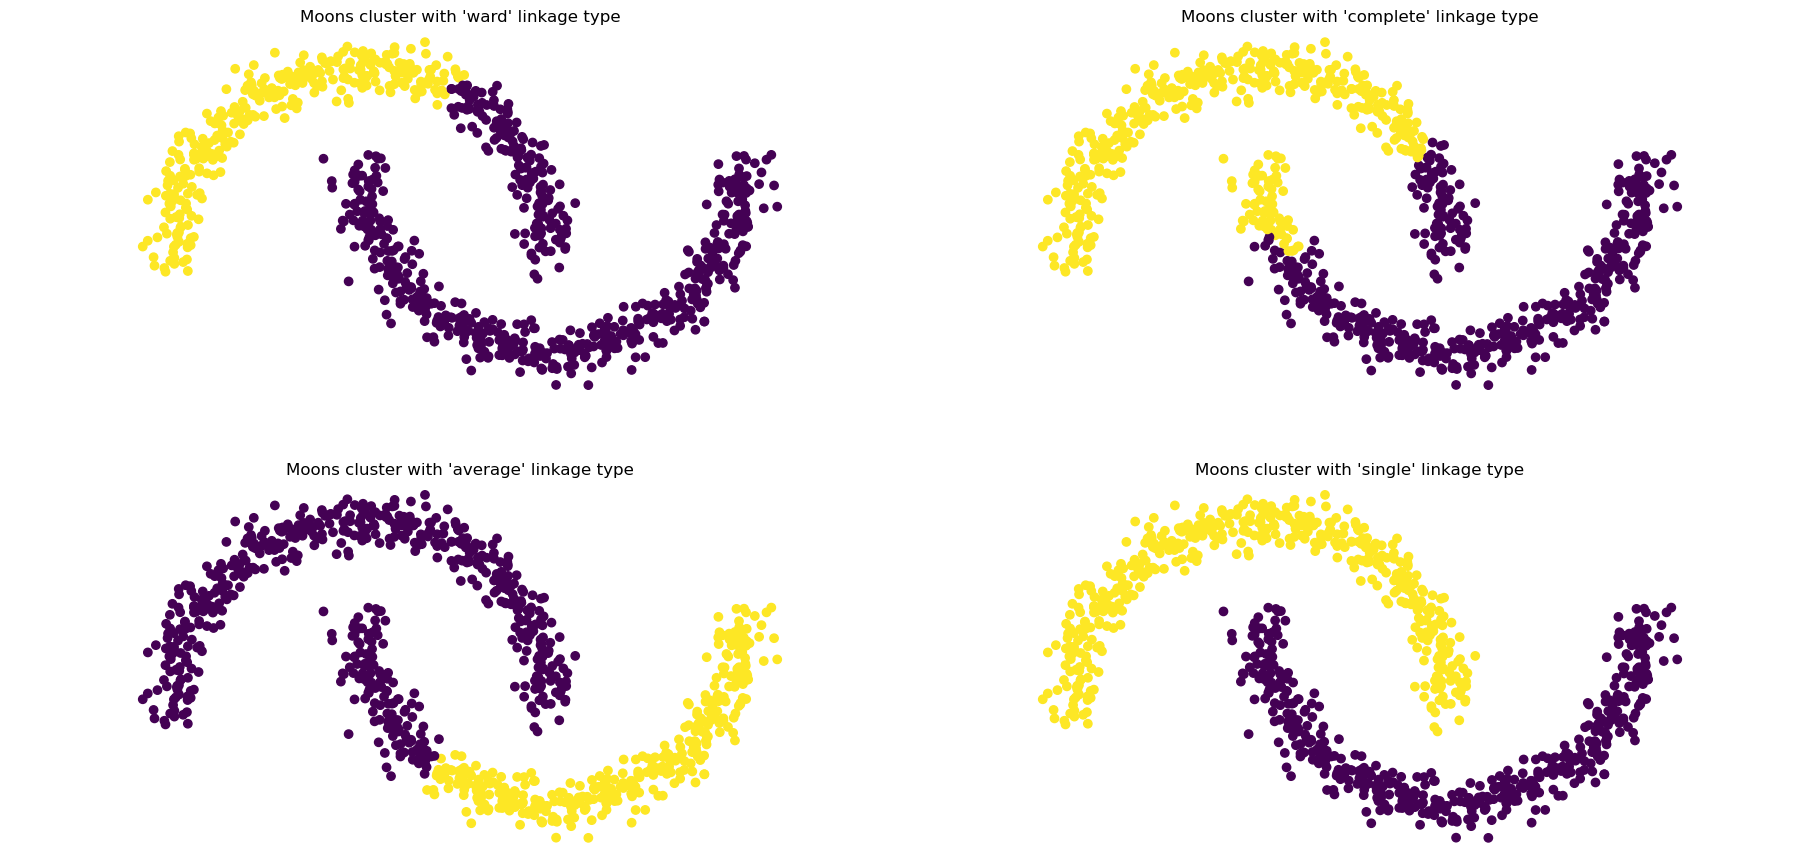

In [31]:
plt.figure(figsize=(18, 10))
for index, linkage in enumerate(("ward",
                              "complete",
                              "average",
                              "single")):
    plt.subplot(2, 2, index + 1)
    model = AgglomerativeClustering(linkage=linkage, n_clusters=2)
    model.fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_)
    plt.title('Moons cluster with %r linkage type' % (linkage),
                      fontdict=dict(verticalalignment='top'))
    plt.axis('equal')
    plt.axis('off')

    plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                                left=0, right=1)


plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

Aquest és el cas contrari al que havia passat al dataset de blobs. Si ens fixem els tres primers mètodes no obtenen l'output desitjat i és només el de tipus single el que aconsegueix obtenir la classificació correcta. Com ja s'ha esmentat és degut a la poca distància entre els veïns més propers d'un mateix grup i a la vegada la separació entre els clústers i l'ausència d'observacions disperses als grups.

In [32]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Circles.<br>
Pots importar les llibraries necessàries.
</div>

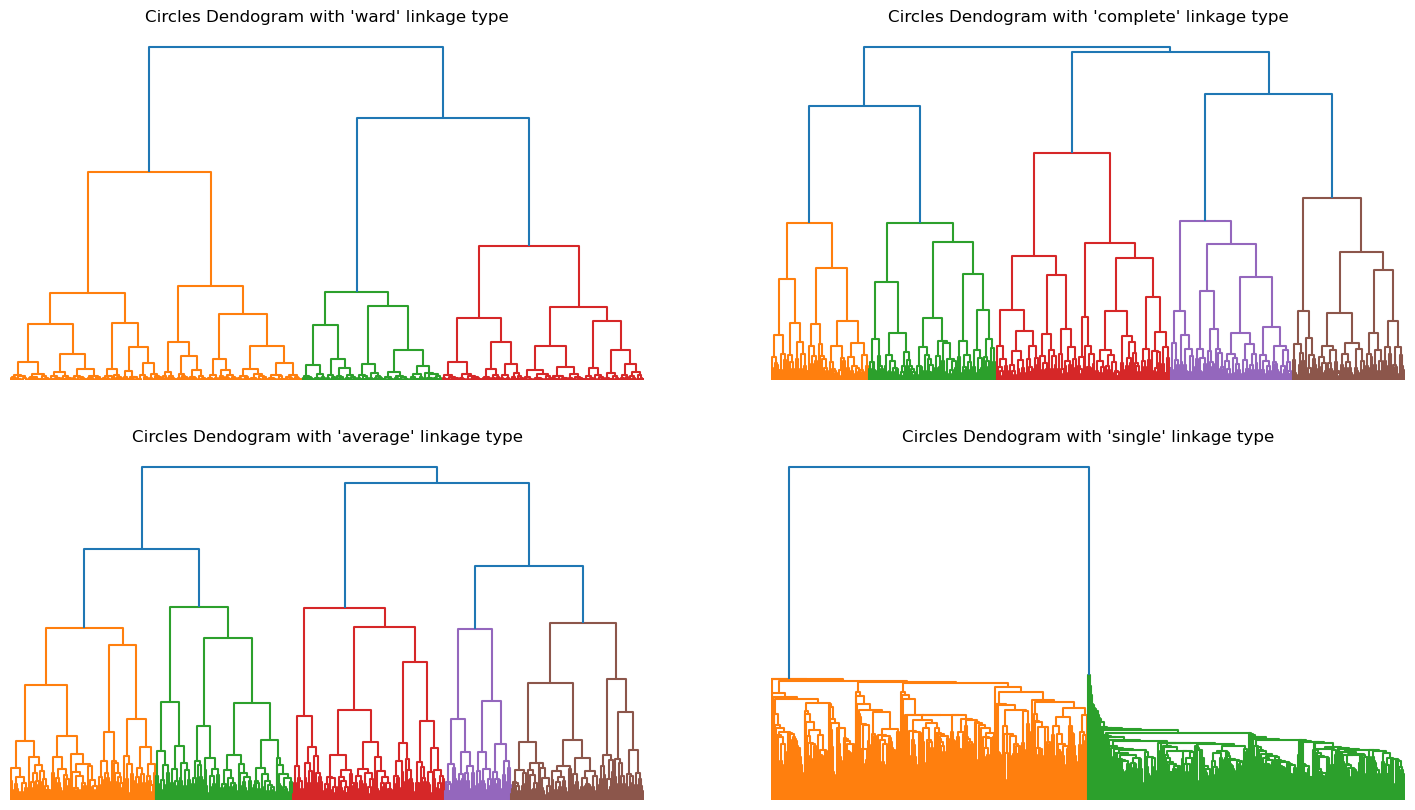

In [33]:
from scipy.cluster.hierarchy import dendrogram , linkage

plt.figure(figsize=(18, 10))
for index, link in enumerate(("ward",
                              "complete",
                              "average",
                              "single")):
    plt.subplot(2, 2, index + 1)
    Z = linkage(X, method = link)
    dendro = dendrogram(Z)
    plt.title('Circles Dendogram with %r linkage type' % (link))
    plt.axis('off')

plt.show()

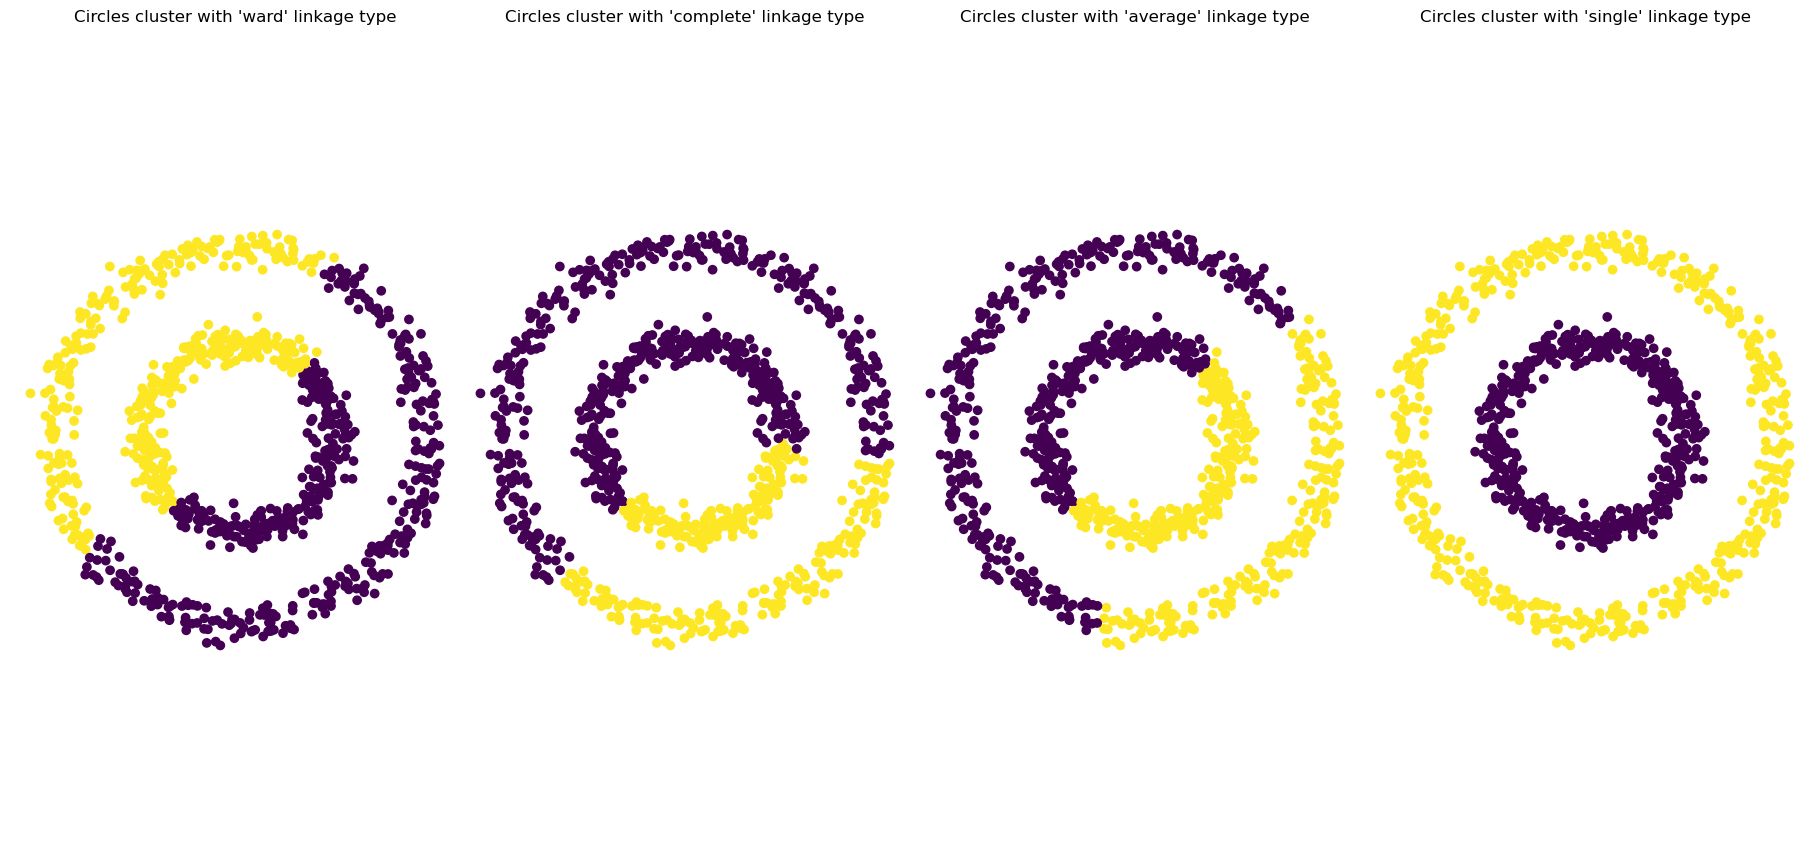

In [34]:
plt.figure(figsize=(18, 10))
for index, linkage in enumerate(("ward",
                              "complete",
                              "average",
                              "single")):
    plt.subplot(1, 4, index + 1)
    model = AgglomerativeClustering(linkage=linkage, n_clusters=2)
    model.fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_)
    plt.title('Circles cluster with %r linkage type' % (linkage),
                      fontdict=dict(verticalalignment='top'))
    plt.axis('equal')
    plt.axis('off')

    plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                                left=0, right=1)


plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

De la mateixa manera que ocorr al dataset de Half Moons l'únic tipus de linkage que aproxima correctament la classificació és el de tipus single. La raó és la mateixa explicada anteriorment.

## 2. Aplicació de reducció de dimensionalitat (2 punts)

És possible aplicar una amplia varietat d'algorismes per la reducció de dimensionalitat. Utilitzarem el dataset MNIST compost de milers de dígits manuscrits del 0 al 9. On cada imatge es composa de 784 píxels (imatges de 28 x 28), fet pel qual partim d'un nombre elevat de dimensions.

In [35]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=5000, test_size=5000)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

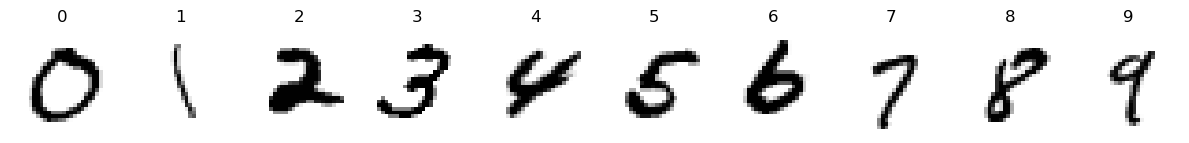

In [36]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

In [37]:
X_train.shape # 5000 mostres amb 784 valors (pixels)

(5000, 784)

Si cada algorisme obté resultats diferents a l'hora de reduir la dimensionalitat, quina representació és la més fidel a la distribució original?

Abans de reduir les 784 dimensions originals de cada mostra a 2 per poder visualizar-les en 2 dimensions, és molt útil coneixer, o com a mínim intuir, l'estructura en alta dimensionalitat de les dades.

Amb aquesta finalitat es pot fer ús del dendograma com a heurística per coneixer la disposició original de les dades i comprovar si la projecció és similar al que es veu amb el dendograma.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> realitza un dendograma amb les mostres de X_train (o un subconjunt d'elles per accelerar el procés) utilitzant el mètode ward. <br>
        Com a consell, la funció dendograma té un paràmetre anomenat no_labels que evita mostrar etiquetes per a cada mostra i posat a True evita mostrar-les, carregant la imatge més de pressa.
</div>

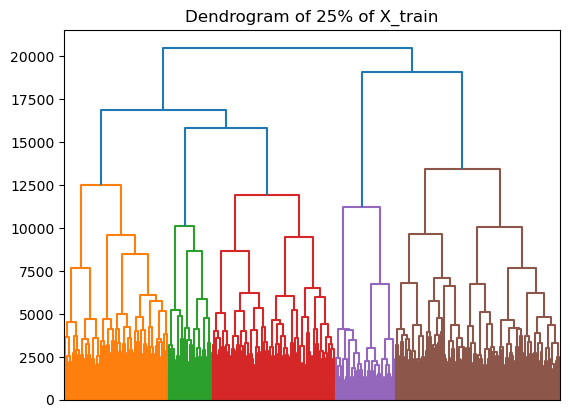

In [38]:
from scipy.cluster.hierarchy import dendrogram , linkage

X_train = pd.DataFrame(X_train)
X_train_sample = X_train.sample(frac = 0.25)
Z = linkage(X_train_sample, method = 'ward')
 
#plotting dendrogram
dendro = dendrogram(Z, no_labels=True)
plt.title('Dendrogram of 25% of X_train')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> apendre una projecció en 2 dimensions de les mostres de X_train amb PCA i projectar el conjunt X_test en 2 dimensions. Després visualitzar-lo en un scatter plot.<br>
    Pots utilitzar les etiquetes de y_test, el paràmetre label (quan generes el scatter) i la funció legend a la visualització per saber la classe corresponent a cada punt i interpretar el resultat de la reducció de dimensionalitat.
</div>

In [39]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
# Normalitzam les dades a treballar
min_max_scaler = preprocessing.MinMaxScaler()
df_train = pd.DataFrame(min_max_scaler.fit_transform(X_train))
df_test = pd.DataFrame(min_max_scaler.fit_transform(X_test))

pca = PCA(n_components=2)
pca.fit(df_train)
x_pca = pca.transform(df_test)
x_pca = pd.DataFrame(data = x_pca, columns = ['PC 1', 'PC 2'])
y_test = pd.DataFrame(y_test, columns=['target'])
finalDf = pd.concat([x_pca, y_test[['target']]], axis = 1)
finalDf.head(5)

,PC 1,PC 2,target
0,-0.162354,-1.178953,5
1,-1.249772,0.613902,3
2,-2.381127,0.618638,3
3,1.235955,-0.824786,5
4,2.347073,-1.046703,5


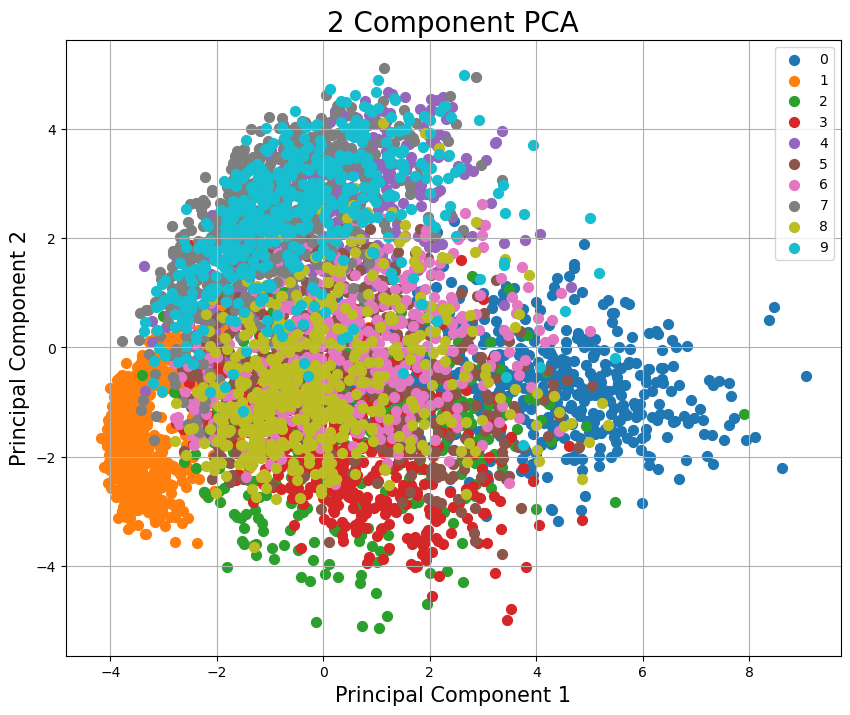

In [40]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


for target in set(finalDf['target']):
    values = finalDf['target'] == target
    ax.scatter(finalDf.loc[values, 'PC 1']
               , finalDf.loc[values, 'PC 2']
               , cmap = 'Spectral'
               , label = target
               , s = 50)
ax.legend()
ax.grid()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què es pot intuir de la projecció? S'assembla al que s'ha representat al dendograma?
</div>

Per començar, el dendograma només identifica 6 grups entre els quals existeixen moltes branques i per tant, subclassificacions. És díficil saber si realment està realitzant una bona aproximació, ja que existeixen moltes posibilitats. Addicionalment, aquesta interpretació pot ser complementada amb l'scatterplot del PCA que a simple vista agrupa correctament els diferents clústers però es superposen amb altres. Això pot resultat un inconvenient, ja que a l'hora de predir utilitzants els dos primers components principals alguns dígits poden ser confosos amb uns altres com per exemple el 6 amb el 8, ja que ambdós comparteixen la mateixa àrea.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> apendre una projecció en 2 dimensions de les mostres de X_train amb UMAP i projectar el conjunt X_test en 2 dimensions. Després visualitzar-lo en un scatter plot.<br>
    Pots utilitzar les etiquetes de y_test, el paràmetre label (quan generes el scatter) i la funció legend a la visualització per saber la classe corresponent a cada punt i interpretar el resultat de la reducció de dimensionalitat.
</div>

In [41]:
umap = umap.UMAP(n_components=2)
umap.fit(df_train)
x_umap = umap.transform(df_test)
x_umap = pd.DataFrame(data = x_umap, columns = ['UMAP 1', 'UMAP 2'])
umap_df = pd.concat([x_umap, y_test[['target']]], axis = 1)

umap_df.head(5)

,UMAP 1,UMAP 2,target
0,3.316581,1.405860,5
1,5.723282,0.607833,3
2,2.436164,3.615602,3
3,3.737129,3.792855,5
4,3.699414,2.010781,5


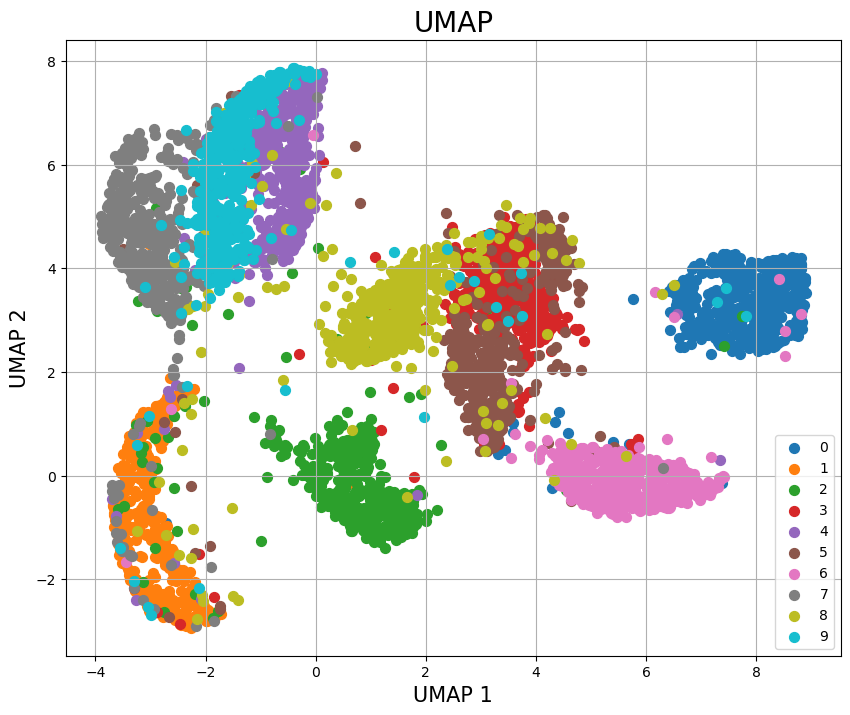

In [42]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('UMAP 1', fontsize = 15)
ax.set_ylabel('UMAP 2', fontsize = 15)
ax.set_title('UMAP', fontsize = 20)

for target in set(umap_df['target']):
    values = umap_df['target'] == target
    ax.scatter(umap_df.loc[values,'UMAP 1'],
               umap_df.loc[values, 'UMAP 2'],
               cmap = 'Spectral',
               label = target,
               s = 50)
ax.legend()
ax.grid()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què es pot intuir de la projecció? S'assembla al que s'ha representat al dendograma?
</div>

El mètode UMAP separa d'una manera més precisa els diferents grups de dígits en una projecció 2D. La principal diferència entre el PCA i el UMAP és que el PCA és un algorisme lineal que asigna el mateix pes a totes les distàncies parelles mentre que UMAP prioritza les distàncies entre veïns.

## 3. Aplicació: segmentació d'imatges de satèlit (4 punts)

Avui en dia els mapes de carreteres, geològics, agrícoles, ... es confeccionen amb imatges de satèlits. Per poder fer això es necessita interpretar aquestes imatges buscant en elles els elements d'interès. Donat el volum actual d'imatges que generen els satèlits, fer la segmentació de forma manual no és una opció i per aquest motiu hi ha tants esforços en la seva automatització.

Assumint que l'espai de píxels té una certa estructura i que els diferents elements a buscar són grups en ella, és raonable pensar que una estratègia de clustering (entre d'altres) pot trobar aquests grups en aquesta estructura, permetent automatitzar la segmentació d'imatges.

Partim d'una imatge amb diversos tipus de vegetació i camins. 

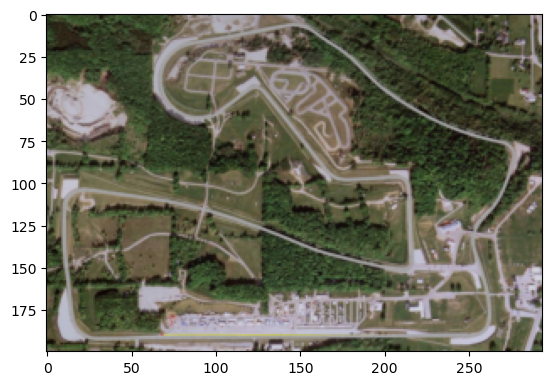

In [43]:
from skimage import io, transform

photo = transform.resize(
    io.imread('https://lh3.googleusercontent.com/-kHq0XyQh3b8/TYFk1h0r2-I/AAAAAAAAAJA/i3rdSELDqxM/s1600/road_america_base.jpg'),
    (200, 294), mode='edge')
plt.imshow(photo)
X = photo.reshape(-1, 3)

Igual que a l'apartat anterior, s'ha donat format d'array a la imatge, amb tantes files com píxels i 3 columnes (una per cada canal).

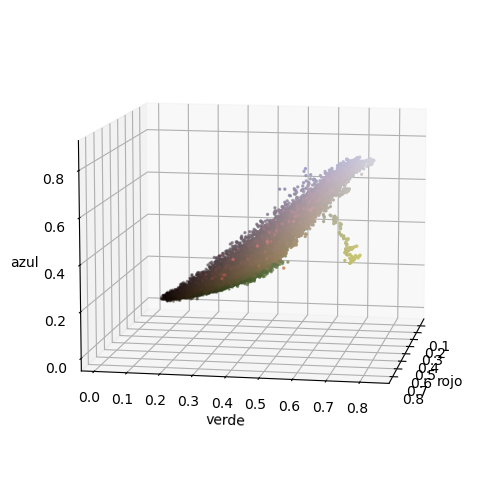

In [44]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pixels_3d(data: "np.array[float]", elev: int = None, azim: int = None) -> None:
    """Visualiza pixeles en un scatter plot 3d (una por canal) con su color correspondiente.
    
    Args:
        data: np.array (puntos, 3)
        elev: int
            angulo de eleveacion en el plano z.
        azim: int
            angulo acimut en el plano x, y.
    """
    assert data.shape[1] == 3, 'Se esperaba un array bidimensional con 3 columnas: (rojo, verde y azul)'
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=2, c=data)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.view_init(elev, azim)
    plt.show()

plot_pixels_3d(X, 10, 10)

A la visualització anterior s'ha representat cada píxel amb el seu color, on les seves coordenades en els tres colors oscilen entre 0 (no té aquesta component) i 1. Podem comprovar com els píxels en coordenades (1, 1, 1) són píxels blancs i els situats en (0, 0, 0) són píxels negres.

Visualitzant en 3 dimensions els píxels de la imatge veiem que en aquest cas no estan tan diferenciats els grups. Però si que els píxels més clars pertanyen a la zona de camins i els més foscos a l'àrea de vegetació.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica una tècnica de clustering per separar els camins de la vegetació i visualitza tant la imatge original com la resultant després d'aplicar la segmentació per comparar el resultat. Quin algorisme has escollit? Per què?
</div>

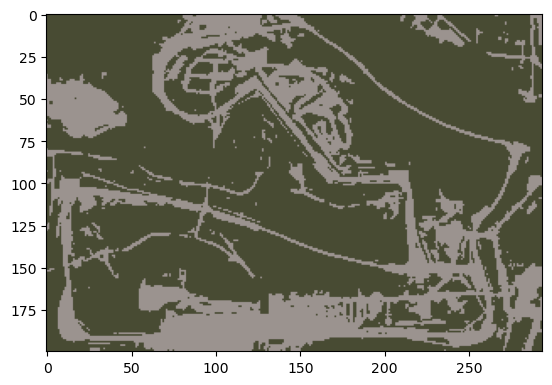

In [45]:
X_k2 = np.copy(X)
k_means2 = cluster.KMeans(n_clusters=2)
y_k2 = np.argmin(k_means2.fit_transform(X), axis=1)
centroids = k_means2.cluster_centers_

X_k2[np.where(y_k2 == 0)] = centroids[0]
X_k2[np.where(y_k2 == 1)] = centroids[1]

X_k2 = X_k2.reshape(200,294,3)
plt.imshow(X_k2)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> torna a aplicar-ho buscant 3 grups de píxels.
</div>

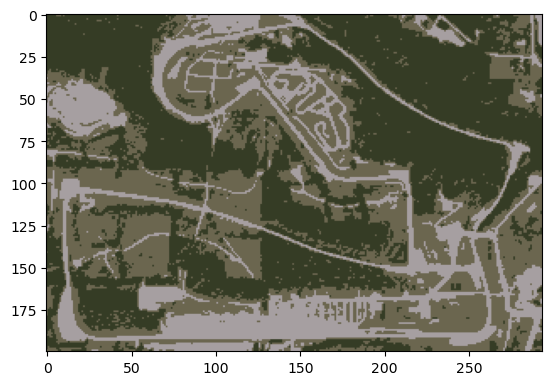

In [46]:
X_k3 = np.copy(X)
k_means3 = cluster.KMeans(n_clusters=3)
y_k3 = np.argmin(k_means3.fit_transform(X), axis=1)
centroids = k_means3.cluster_centers_

X_k3[np.where(y_k3 == 0)] = centroids[0]
X_k3[np.where(y_k3 == 1)] = centroids[1]
X_k3[np.where(y_k3 == 2)] = centroids[2]

X_k3 = X_k3.reshape(200,294,3)
plt.imshow(X_k3)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Quina regió representa cadascun d'ells?
</div>

Es pot observar com en la primera segmentació se separa correctament la vegetació (verd) dels camins (marró) mentre que amb k=3 es distingeix entre els arbres o bosc, vegetació i camins.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> l'últim pas consisteix en aplicar el clustering i separar els camins del fons, posant aquest últim en negre (omplint amb 0 els valors dels píxels del fons). Així quedaran segmentats de forma automàtica els camins de la resta de la fotografia.
</div>

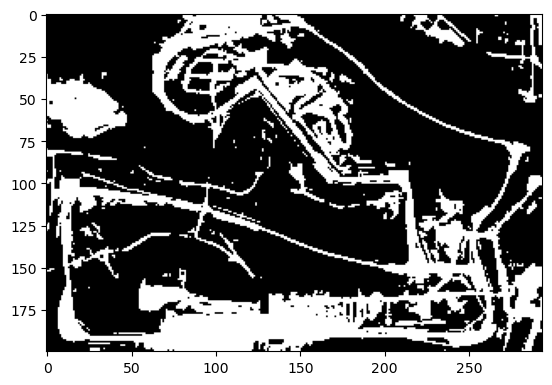

In [47]:
X_black = np.copy(X)

k_means_black = cluster.KMeans(n_clusters=2)
y_black = np.argmin(k_means_black.fit_transform(X_black), axis=1)
centroids = k_means_black.cluster_centers_

if centroids[0][0] < centroids [1][0]:
    X_black[np.where(y_black == 0)] = [0, 0, 0]
    X_black[np.where(y_black == 1)] = [1, 1, 1]
else:
    X_black[np.where(y_black == 0)] = [1, 1, 1]
    X_black[np.where(y_black == 1)] = [0, 0, 0]

X_black = X_black.reshape(200,294,3)
plt.imshow(X_black)